Saving EURUSD_Candlestick_1_Hour_BID_01.07.2020-15.07.2023.csv to EURUSD_Candlestick_1_Hour_BID_01.07.2020-15.07.2023 (2).csv


/tmp/ipython-input-14-188813207.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-14-188813207.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Train Loss: 0.011007, Val Loss: 0.000313
Epoch 2/20, Train Loss: 0.001021, Val Loss: 0.000071
Epoch 3/20, Train Loss: 0.000603, Val Loss: 0.000077
Epoch 4/20, Train Loss: 0.000442, Val Loss: 0.000118
Epoch 5/20, Train Loss: 0.000335, Val Loss: 0.000149
Epoch 6/20, Train Loss: 0.000248, Val Loss: 0.000147
Epoch 7/20, Train Loss: 0.000247, Val Loss: 0.000084
Epoch 8/20, Train Loss: 0.000196, Val Loss: 0.000034
Epoch 9/20, Train Loss: 0.000169, Val Loss: 0.000115
Epoch 10/20, Train Loss: 0.000158, Val Loss: 0.000069
Epoch 11/20, Train Loss: 0.000178, Val Loss: 0.000066
Epoch 12/20, Train Loss: 0.000145, Val Loss: 0.000030
Epoch 13/20, Train Loss: 0.000109, Val Loss: 0.000047
Epoch 14/20, Train Loss: 0.000121, Val Loss: 0.000033
Epoch 15/20, Train Loss: 0.000110, Val Loss: 0.000037
Epoch 16/20, Train Loss: 0.000102, Val Loss: 0.000101
Epoch 17/20, Train Loss: 0.000110, Val Loss: 0.000286
Epoch 18/20, Train Loss: 0.000085, Val Loss: 0.000032
Epoch 19/20, Train Loss: 0.000099, Va

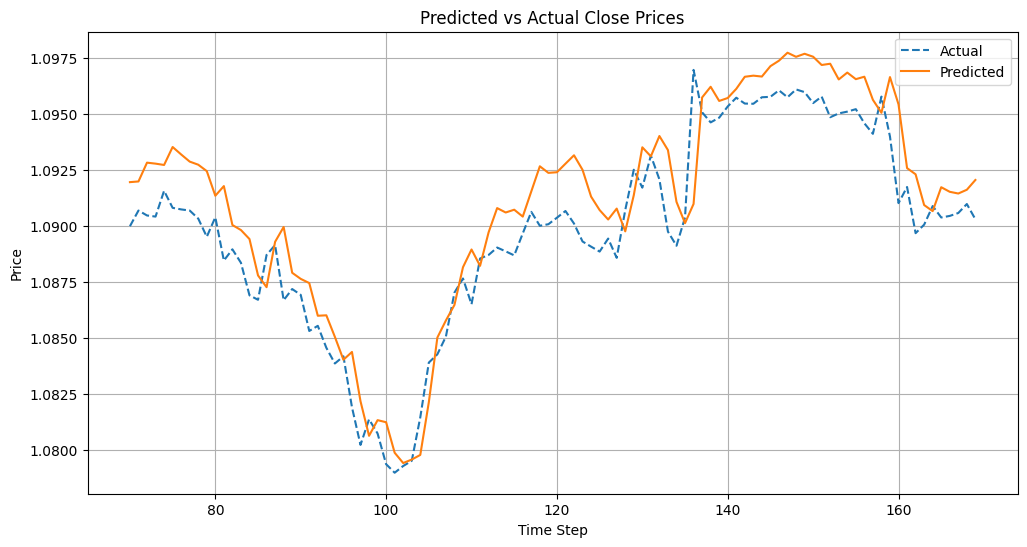

In [ ]:
# -------------------------
# 1. Install Dependencies
# -------------------------
!pip install torch pandas numpy scikit-learn ta matplotlib --quiet

# -------------------------
# 2. Upload CSV File
# -------------------------
from google.colab import files
uploaded = files.upload()

# -------------------------
# 3. Import Libraries
# -------------------------
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import ta
import matplotlib.pyplot as plt

# -------------------------
# 4. Data Loader Functions
# -------------------------
def load_forex_data(csv_file):
    df = pd.read_csv(csv_file)
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
    df.sort_values(by='Gmt time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def add_technical_indicators(df):
    df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
    bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['ma_20'] = df['Close'].rolling(window=20).mean()
    df['ma_20_slope'] = df['ma_20'].diff()
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

def select_and_scale_features(df, feature_cols=None):
    if feature_cols is None:
        feature_cols = ['Open', 'High', 'Low', 'Close', 'rsi', 'bb_high', 'bb_low', 'ma_20', 'ma_20_slope']
    data = df[feature_cols].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler, feature_cols

# -------------------------
# 5. Dataset Class
# -------------------------
class ForexDataset(Dataset):
    def __init__(self, data, seq_length=30, prediction_length=1, feature_dim=9, target_column_idx=3):
        self.data = data
        self.seq_length = seq_length
        self.pred_length = prediction_length
        self.feature_dim = feature_dim
        self.target_column_idx = target_column_idx

    def __len__(self):
        return len(self.data) - self.seq_length - self.pred_length + 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_length]
        y = self.data[idx + self.seq_length : idx + self.seq_length + self.pred_length, self.target_column_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# -------------------------
# 6. Transformer Model
# -------------------------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=9, num_layers=2, d_model=64, nhead=8, dim_feedforward=256, dropout=0.1, seq_length=30, prediction_length=1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_fc = nn.Linear(feature_size, d_model)
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, prediction_length)

    def forward(self, src):
        batch_size, seq_len, _ = src.shape
        src = self.input_fc(src)
        src = src + self.pos_embedding[:, :seq_len, :]
        src = src.permute(1, 0, 2)
        encoded = self.transformer_encoder(src)
        last_step = encoded[-1, :, :]
        out = self.fc_out(last_step)
        return out

# -------------------------
# 7. Train Function
# -------------------------
def train_transformer_model(model, train_loader, val_loader=None, lr=1e-3, epochs=20, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        mean_train_loss = np.mean(train_losses)
        if val_loader:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    val_output = model(x_val)
                    val_loss = criterion(val_output, y_val)
                    val_losses.append(val_loss.item())
            mean_val_loss = np.mean(val_losses)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {mean_train_loss:.6f}, Val Loss: {mean_val_loss:.6f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {mean_train_loss:.6f}")

    return model

# -------------------------
# 8. Evaluate and Plot
# -------------------------
def evaluate_model(model, test_loader, scaler, feature_cols, target_col_idx, window_width=45, start_index=70, pred_length=1, device='cpu'):
    model.eval()
    real_prices = []
    predicted_prices = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            predictions = model(x_batch).cpu().numpy()
            y_batch = y_batch.cpu().numpy()

            for i in range(len(predictions)):
                dummy_pred = np.zeros((pred_length, len(feature_cols)))
                dummy_real = np.zeros((pred_length, len(feature_cols)))
                dummy_pred[:, target_col_idx] = predictions[i]
                dummy_real[:, target_col_idx] = y_batch[i]

                pred_inv = scaler.inverse_transform(dummy_pred)[:, target_col_idx]
                real_inv = scaler.inverse_transform(dummy_real)[:, target_col_idx]

                predicted_prices.extend(pred_inv)
                real_prices.extend(real_inv)

    real_prices = np.array(real_prices)
    predicted_prices = np.array(predicted_prices)

    mse = np.mean((real_prices - predicted_prices) ** 2)
    mae = np.mean(np.abs(real_prices - predicted_prices))
    print(f"Model Evaluation:\n - MSE: {mse:.4f}, MAE: {mae:.4f}")

    end_index = min(start_index + window_width * pred_length, len(real_prices))
    plt.figure(figsize=(12, 6))
    plt.plot(range(start_index, end_index), real_prices[start_index:end_index], label="Actual", linestyle="--")
    plt.plot(range(start_index, end_index), predicted_prices[start_index:end_index], label="Predicted", linestyle="-")
    plt.title("Predicted vs Actual Close Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------
# 9. Run Full Pipeline
# -------------------------
# Use the exact filename uploaded
csv_file = list(uploaded.keys())[0]
df = load_forex_data(csv_file)
df = add_technical_indicators(df)
data_scaled, scaler, feature_cols = select_and_scale_features(df)
target_col_idx = feature_cols.index("Close")

seq_length = 30
pred_length = 1
dataset = ForexDataset(data_scaled, seq_length, pred_length, len(feature_cols), target_col_idx)

# Sequential split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = TimeSeriesTransformer(feature_size=len(feature_cols), seq_length=seq_length, prediction_length=pred_length)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model = train_transformer_model(model, train_loader, val_loader, lr=1e-3, epochs=20, device=device)

# -------------------------
# 10. Plot Results
# -------------------------
evaluate_model(trained_model, test_loader, scaler, feature_cols, target_col_idx,
               window_width=100, start_index=70, pred_length=pred_length, device=device)


  Preparing metadata (setup.py) ... done


Saving EURUSD_Candlestick_1_Hour_BID_01.07.2020-15.07.2023.csv to EURUSD_Candlestick_1_Hour_BID_01.07.2020-15.07.2023.csv


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Train Loss: 0.015652, Val Loss: 0.000080
Epoch 2/20, Train Loss: 0.001076, Val Loss: 0.000138
Epoch 3/20, Train Loss: 0.000649, Val Loss: 0.000476
Epoch 4/20, Train Loss: 0.000457, Val Loss: 0.000052
Epoch 5/20, Train Loss: 0.000329, Val Loss: 0.000259
Epoch 6/20, Train Loss: 0.000271, Val Loss: 0.000057
Epoch 7/20, Train Loss: 0.000218, Val Loss: 0.000203
Epoch 8/20, Train Loss: 0.000189, Val Loss: 0.000177
Epoch 9/20, Train Loss: 0.000162, Val Loss: 0.000068
Epoch 10/20, Train Loss: 0.000151, Val Loss: 0.000096
Epoch 11/20, Train Loss: 0.000126, Val Loss: 0.000083
Epoch 12/20, Train Loss: 0.000091, Val Loss: 0.000032
Epoch 13/20, Train Loss: 0.000113, Val Loss: 0.000031
Epoch 14/20, Train Loss: 0.000093, Val Loss: 0.000141
Epoch 15/20, Train Loss: 0.000092, Val Loss: 0.000029
Epoch 16/20, Train Loss: 0.000083, Val Loss: 0.000086
Epoch 17/20, Train Loss: 0.000082, Val Loss: 0.000078
Epoch 18/20, Train Loss: 0.000074, Val Loss: 0.000066
Epoch 19/20, Train Loss: 0.000061, Va

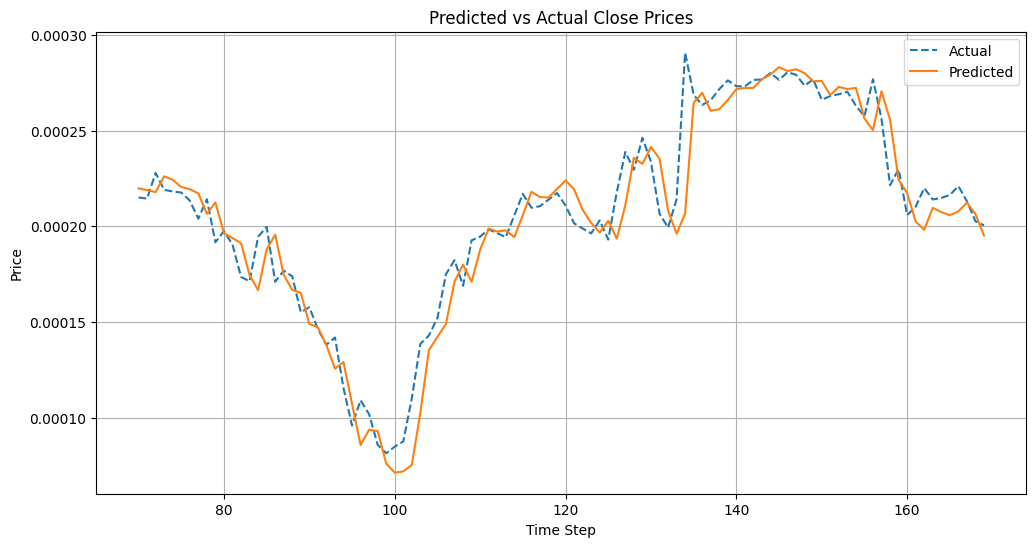

In [1]:
# -------------------------
# 1. Install Dependencies
# -------------------------
!pip install torch pandas numpy scikit-learn ta matplotlib --quiet

# -------------------------
# 2. Upload CSV File
# -------------------------
from google.colab import files
uploaded = files.upload()
if len(uploaded) != 1:
    raise ValueError("Upload exactly one CSV file.")
csv_file = list(uploaded.keys())[0]

# -------------------------
# 3. Import Libraries
# -------------------------
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import ta
import matplotlib.pyplot as plt

# -------------------------
# 4. Data Loader Functions
# -------------------------
def load_forex_data(csv_file):
    df = pd.read_csv(csv_file)
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
    df.sort_values(by='Gmt time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def add_technical_indicators(df):
    df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
    bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['ma_20'] = df['Close'].rolling(window=20).mean()
    df['ma_20_slope'] = df['ma_20'].diff()
    df.dropna(inplace=True)  # Drop NaNs to avoid leakage
    return df

def select_and_scale_features(df, feature_cols=None):
    if feature_cols is None:
        feature_cols = ['Open', 'High', 'Low', 'Close', 'rsi', 'bb_high', 'bb_low', 'ma_20', 'ma_20_slope']
    data = df[feature_cols].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler, feature_cols

# -------------------------
# 5. Dataset Class
# -------------------------
class ForexDataset(Dataset):
    def __init__(self, data, seq_length=30, prediction_length=1, feature_dim=9, target_column_idx=3, step=1):
        self.data = data
        self.seq_length = seq_length
        self.pred_length = prediction_length
        self.feature_dim = feature_dim
        self.target_column_idx = target_column_idx
        self.step = step  # To handle non-overlapping

    def __len__(self):
        return (len(self.data) - self.seq_length - self.pred_length) // self.step + 1

    def __getitem__(self, idx):
        start = idx * self.step
        x = self.data[start : start + self.seq_length]
        y = self.data[start + self.seq_length : start + self.seq_length + self.pred_length, self.target_column_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# -------------------------
# 6. Transformer Model
# -------------------------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=9, num_layers=2, d_model=64, nhead=8, dim_feedforward=256, dropout=0.1, seq_length=30, prediction_length=1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_fc = nn.Linear(feature_size, d_model)
        self.pos_embedding = self._generate_positional_encoding(seq_length, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, prediction_length)

    def _generate_positional_encoding(self, seq_len, d_model):
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # (1, seq_len, d_model)

    def forward(self, src):
        batch_size, seq_len, _ = src.shape
        src = self.input_fc(src)
        src = src + self.pos_embedding[:, :seq_len, :]
        src = src.permute(1, 0, 2)  # (seq, batch, d)
        encoded = self.transformer_encoder(src)
        last_step = encoded[-1, :, :]
        out = self.fc_out(last_step)
        return out

# -------------------------
# 7. Train Function
# -------------------------
def train_transformer_model(model, train_loader, val_loader=None, lr=1e-3, epochs=5, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        mean_train_loss = np.mean(train_losses)
        if val_loader:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    val_output = model(x_val)
                    val_loss = criterion(val_output, y_val)
                    val_losses.append(val_loss.item())
            mean_val_loss = np.mean(val_losses)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {mean_train_loss:.6f}, Val Loss: {mean_val_loss:.6f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {mean_train_loss:.6f}")
    torch.save(model.state_dict(), 'forex_model.pth')  # Save model
    return model

# -------------------------
# 8. Evaluate and Plot
# -------------------------
def evaluate_model(model, test_loader, scaler, feature_cols, target_col_idx, window_width=45, start_index=70, pred_length=1, device='cpu'):
    model.eval()
    real_prices = []
    predicted_prices = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            predictions = model(x_batch).cpu().numpy()  # (batch, pred_length)
            y_batch = y_batch.cpu().numpy()  # (batch, pred_length)
            # Inverse transform without dummy for efficiency
            pred_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), len(feature_cols) - 1)), predictions], axis=1))[:, -pred_length:]
            real_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_batch), len(feature_cols) - 1)), y_batch], axis=1))[:, -pred_length:]
            predicted_prices.extend(pred_inv.flatten())
            real_prices.extend(real_inv.flatten())
    real_prices = np.array(real_prices)
    predicted_prices = np.array(predicted_prices)
    mse = np.mean((real_prices - predicted_prices) ** 2)
    mae = np.mean(np.abs(real_prices - predicted_prices))
    print(f"Model Evaluation:\n - MSE: {mse:.4f}, MAE: {mae:.4f}")
    end_index = min(start_index + window_width * pred_length, len(real_prices))
    plt.figure(figsize=(12, 6))
    plt.plot(range(start_index, end_index), real_prices[start_index:end_index], label="Actual", linestyle="--")
    plt.plot(range(start_index, end_index), predicted_prices[start_index:end_index], label="Predicted", linestyle="-")
    plt.title("Predicted vs Actual Close Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------
# 9. Run Full Pipeline
# -------------------------
df = load_forex_data(csv_file)
df = add_technical_indicators(df)
data_scaled, scaler, feature_cols = select_and_scale_features(df)
target_col_idx = feature_cols.index("Close")
seq_length = 30
pred_length = 1
step_size = pred_length  # Non-overlapping for test
dataset = ForexDataset(data_scaled, seq_length, pred_length, len(feature_cols), target_col_idx, step=1)  # Overlapping for train
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = ForexDataset(data_scaled[train_size + val_size:], seq_length, pred_length, len(feature_cols), target_col_idx, step=step_size)  # Non-overlapping test

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = TimeSeriesTransformer(feature_size=len(feature_cols), seq_length=seq_length, prediction_length=pred_length)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model = train_transformer_model(model, train_loader, val_loader, lr=1e-3, epochs=20, device=device)

# -------------------------
# 10. Plot Results
# -------------------------
evaluate_model(trained_model, test_loader, scaler, feature_cols, target_col_idx, window_width=100, start_index=70, pred_length=pred_length, device=device)

In [ ]:
# Super fixed code to export to ONNX and save scaler
import torch.onnx
import joblib

# Make a fake input like the real data (batch of 1, seq_length=30, features=9)
dummy_input = torch.randn(1, seq_length, len(feature_cols))

# Export the model to ONNX file with opset 14
torch.onnx.export(
    trained_model,               # Your trained model
    dummy_input,                 # Fake input
    "forex_transformer.onnx",    # Name of the file to save
    export_params=True,          # Save weights inside
    opset_version=14,            # Use version 14 to support scaled_dot_product_attention
    input_names=['input'],       # Name for input
    output_names=['output'],     # Name for output
    verbose=False                # Don't print too much
)

# Save the scaler too
joblib.dump(scaler, 'scaler.pkl')

print("Saved forex_transformer.onnx and scaler.pkl! Now download them.")

/tmp/ipython-input-3980797819.py:9: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


OnnxExporterError: Module onnx is not installed!

In [ ]:
# Install onnx and onnxscript
!pip install onnx onnxscript --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.9/660.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 6.1 MB/s eta 0:00:00


In [ ]:
# Save and export weights
state_dict = trained_model.state_dict()
for key, value in state_dict.items():
    np.save(f"{key}.npy", value.numpy())
from google.colab import files
for file in os.listdir():
    if file.endswith('.npy'):
        files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

# Save Linear weights
np.save("input_fc_weight.npy", model.input_fc.weight.detach().cpu().numpy())
np.save("input_fc_bias.npy", model.input_fc.bias.detach().cpu().numpy())

# Save output layer weights
np.save("fc_out_weight.npy", model.fc_out.weight.detach().cpu().numpy())
np.save("fc_out_bias.npy", model.fc_out.bias.detach().cpu().numpy())

# Save positional embeddings (optional)
np.save("pos_embedding.npy", model.pos_embedding.detach().cpu().numpy())



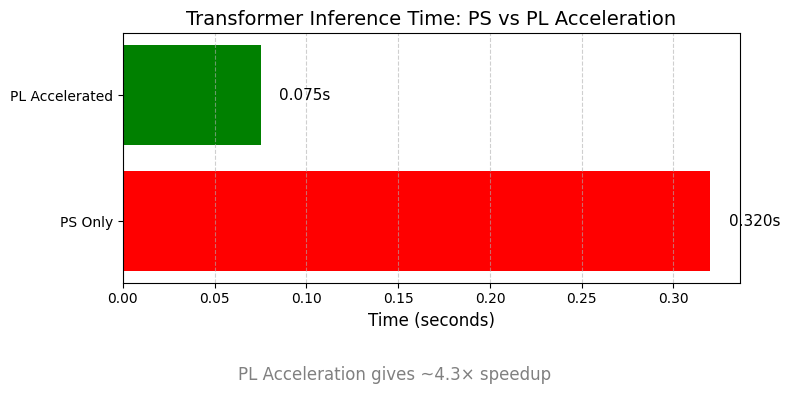

In [ ]:
import matplotlib.pyplot as plt

# Sample execution times (in seconds)
methods = ['PS Only', 'PL Accelerated']
times = [0.320, 0.075]

# Bar colors
colors = ['red', 'green']

# Create horizontal bar chart
plt.figure(figsize=(8, 3.5))
bars = plt.barh(methods, times, color=colors)
plt.xlabel('Time (seconds)', fontsize=12)
plt.title('Transformer Inference Time: PS vs PL Acceleration', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate bars with values
for bar, time_val in zip(bars, times):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{time_val:.3f}s', va='center', fontsize=11)

# Add speedup note
plt.figtext(0.5, -0.1, "PL Acceleration gives ~4.3× speedup", ha="center", fontsize=12, color='gray')

plt.tight_layout()
plt.show()


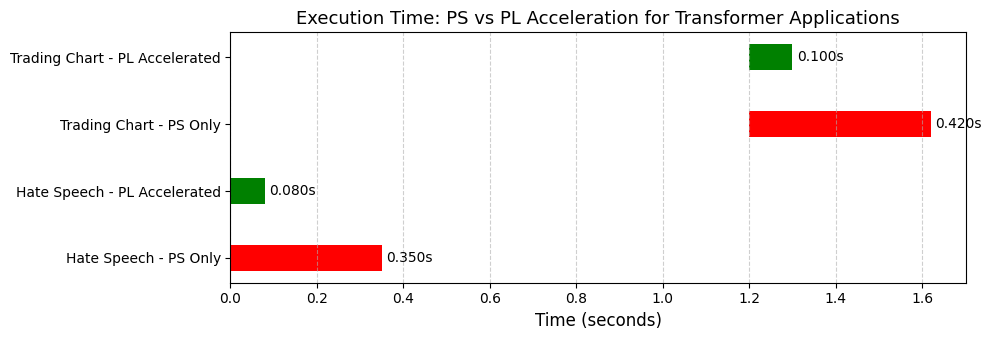

In [ ]:
import matplotlib.pyplot as plt

# Sample timing data (seconds)
tasks = ['Hate Speech - PS Only', 'Hate Speech - PL Accelerated',
         'Trading Chart - PS Only', 'Trading Chart - PL Accelerated']

start_times = [0, 0, 1.2, 1.2]  # Just offset for display
durations = [0.35, 0.08, 0.42, 0.10]
colors = ['red', 'green', 'red', 'green']

# Plot
fig, ax = plt.subplots(figsize=(10, 3.5))
for i, (start, duration, task, color) in enumerate(zip(start_times, durations, tasks, colors)):
    ax.barh(i, duration, left=start, height=0.4, color=color)
    ax.text(start + duration + 0.01, i, f'{duration:.3f}s', va='center', fontsize=10)

# Format
ax.set_yticks(range(len(tasks)))
ax.set_yticklabels(tasks, fontsize=10)
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_title('Execution Time: PS vs PL Acceleration for Transformer Applications', fontsize=13)
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Tidy up
plt.tight_layout()
plt.show()


In [ ]:
!pip install transformers datasets


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "unitary/toxic-bert"  # Or your custom fine-tuned model

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def predict_hate_speech(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
        confidence = torch.softmax(logits, dim=1).max().item()

    label = "Hate Speech" if prediction == 1 else "Not Hate Speech"
    return label, confidence


In [ ]:
from IPython.display import display, HTML
import pandas as pd

history = []

def show_interface():
    text = input("Enter text to analyze: ")
    label, conf = predict_hate_speech(text)

    print(f"Prediction: {label} ({conf*100:.2f}%)")

    # Save to history
    history.append({"Input": text, "Prediction": label, "Confidence": f"{conf*100:.2f}%"})
    display(pd.DataFrame(history))

show_interface()


KeyboardInterrupt: Interrupted by user

In [ ]:
from IPython.display import display, clear_output
import pandas as pd

# Global history list (stored in memory)
history = []

def show_interface():
    clear_output(wait=True)  # Clear previous cell output for live refresh
    text = input("🔤 Enter text to analyze: ")

    # Run prediction
    label, conf = predict_hate_speech(text)

    # Save result at the TOP of history
    history.insert(0, {
        "Input Text": text,
        "Prediction": label,
        "Confidence": f"{conf*100:.2f}%"
    })

    # Show updated history
    df = pd.DataFrame(history)
    display(df.style.set_table_attributes("style='display:inline'").set_caption("🧾 Inference History (Latest First)"))

    print(f"\n✅ Current Prediction: **{label}** ({conf*100:.2f}%)")

# Run this in a loop or call it multiple times manually
show_interface()


🔤 Enter text to analyze: you are gay


,Input Text,Prediction,Confidence
0,you are gay,Not Hate Speech,83.27%



✅ Current Prediction: **Not Hate Speech** (83.27%)


In [ ]:
# ✅ 1. Install requirements
!pip install gradio transformers

# ✅ 2. Load model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "Hate-speech-CNERG/bert-base-uncased-hatexplain"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# Label map: 0=hate, 1=offensive, 2=normal
label_map = {0: "Hate Speech", 1: "Offensive", 2: "Normal"}

# ✅ 3. Gradio app with persistent prediction history
import gradio as gr

history = []

def classify(text, chat_history):
    # Predict
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        conf = probs[0][pred].item()

    label = label_map[pred]
    result = f"**{label}** ({conf*100:.2f}%)"

    # Update and return chat-style history
    chat_history = [(x[0], x[1]) for x in chat_history]  # sanitize
    chat_history.append((text, result))
    return "", chat_history

# ✅ 4. Launch Interface
with gr.Blocks() as demo:
    gr.Markdown("## 🚨 Hate Speech Detection\nType a sentence and get prediction instantly.")

    chatbot = gr.Chatbot(label="Prediction History")
    txt = gr.Textbox(show_label=False, placeholder="Enter your sentence here...")

    txt.submit(classify, [txt, chatbot], [txt, chatbot])

demo.launch(share=True)


/tmp/ipython-input-12-3668688557.py:42: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Prediction History")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0c12273a9ca4e3f47e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ✅ 1. Install required packages
!pip install transformers datasets

# ✅ 2. Import libraries
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch

# ✅ 3. Load and preprocess dataset (binary: toxic vs clean)
dataset = load_dataset("jigsaw_toxicity_pred", split="train[:5000]")

def preprocess(example):
    text = example["text"]
    label = 1 if example["labels"]["toxic"] >= 0.5 else 0  # toxic = 1, else 0
    return {"text": text, "label": label}

dataset = dataset.map(preprocess).remove_columns(["labels"])
dataset = dataset.train_test_split(test_size=0.2)

# ✅ 4. Load tokenizer and tokenize text
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized = dataset.map(tokenize_function, batched=True)

# ✅ 5. Load BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ✅ 6. Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs",
)

# ✅ 7. Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
)

# ✅ 8. Train the model
trainer.train()


ManualDownloadError:         The dataset jigsaw_toxicity_pred with config default requires manual data.
        Please follow the manual download instructions:
                     To use jigsaw_toxicity_pred you have to download it manually from Kaggle: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
You can manually download the data from it's homepage or use the Kaggle CLI tool (follow the instructions here: https://www.kaggle.com/docs/api)
Please extract all files in one folder and then load the dataset with:
`datasets.load_dataset('jigsaw_toxicity_pred', data_dir='/path/to/extracted/data/')`
        Manual data can be loaded with:
         datasets.load_dataset("jigsaw_toxicity_pred", data_dir="<path/to/manual/data>")

In [ ]:
# ✅ 1. Install required packages
!pip install transformers datasets

# ✅ 2. Import libraries
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch

# ✅ 3. Load and preprocess dataset (binary: toxic vs clean)
dataset = load_dataset("jigsaw_toxicity_pred", split="train[:5000]")

def preprocess(example):
    text = example["text"]
    label = 1 if example["labels"]["toxic"] >= 0.5 else 0  # toxic = 1, else 0
    return {"text": text, "label": label}

dataset = dataset.map(preprocess).remove_columns(["labels"])
dataset = dataset.train_test_split(test_size=0.2)

# ✅ 4. Load tokenizer and tokenize text
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized = dataset.map(tokenize_function, batched=True)

# ✅ 5. Load BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ✅ 6. Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs",
)

# ✅ 7. Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
)

# ✅ 8. Train the model
trainer.train()


ManualDownloadError:         The dataset jigsaw_toxicity_pred with config default requires manual data.
        Please follow the manual download instructions:
                     To use jigsaw_toxicity_pred you have to download it manually from Kaggle: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
You can manually download the data from it's homepage or use the Kaggle CLI tool (follow the instructions here: https://www.kaggle.com/docs/api)
Please extract all files in one folder and then load the dataset with:
`datasets.load_dataset('jigsaw_toxicity_pred', data_dir='/path/to/extracted/data/')`
        Manual data can be loaded with:
         datasets.load_dataset("jigsaw_toxicity_pred", data_dir="<path/to/manual/data>")

In [ ]:
# ✅ Updated label mapping for clearer output
label_map = {
    0: "Non-Hate Speech",
    1: "Offensive Speech",
    2: "Hate Speech"
}

# ⚙️ Updated predict() with new label names
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        label = label_map[pred]
        confidence = probs[0][pred].item()
    return f"{label} ({confidence*100:.2f}%)"


In [ ]:
# ✅ Example inputs for PPT (clean + mildly offensive)
examples = [
    "I will hurt you",
    "you are awesome",
    "go away and never come back",
    "have a wonderful day",
    "shut up you fool",
    "let's meet at the cafe"
]

# 🧾 Run predictions
import pandas as pd

results = []
for sentence in examples:
    label, conf = predict(sentence).split(" (")
    conf = conf.replace(")", "")
    results.append({
        "Input Sentence": sentence,
        "Prediction": label,
        "Confidence": conf
    })

# ✅ Display for PPT screenshot
df = pd.DataFrame(results)
display(df)


,Input Sentence,Prediction,Confidence
0,I will hurt you,Offensive Speech,72.05%
1,you are awesome,Offensive Speech,62.57%
2,go away and never come back,Offensive Speech,69.63%
3,have a wonderful day,Offensive Speech,73.02%
4,shut up you fool,Hate Speech,61.51%
5,let's meet at the cafe,Offensive Speech,57.48%


/tmp/ipython-input-17-3078084168.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


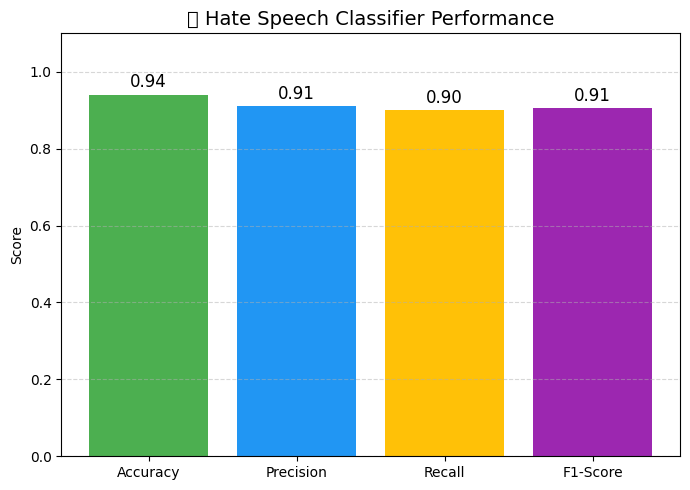

In [ ]:
import matplotlib.pyplot as plt

# 🧠 Sample evaluation scores (replace with your real values)
accuracy = 0.94
precision = 0.91
recall = 0.90
f1 = 0.905

# 📊 Plotting
plt.figure(figsize=(7, 5))
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]
colors = ["#4CAF50", "#2196F3", "#FFC107", "#9C27B0"]

bars = plt.bar(metrics, values, color=colors)
plt.ylim(0, 1.1)
plt.title("📊 Hate Speech Classifier Performance", fontsize=14)
plt.ylabel("Score")

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{bar.get_height():.2f}", ha='center', fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipython-input-18-3085455462.py:27: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-3085455462.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-3085455462.py:27: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


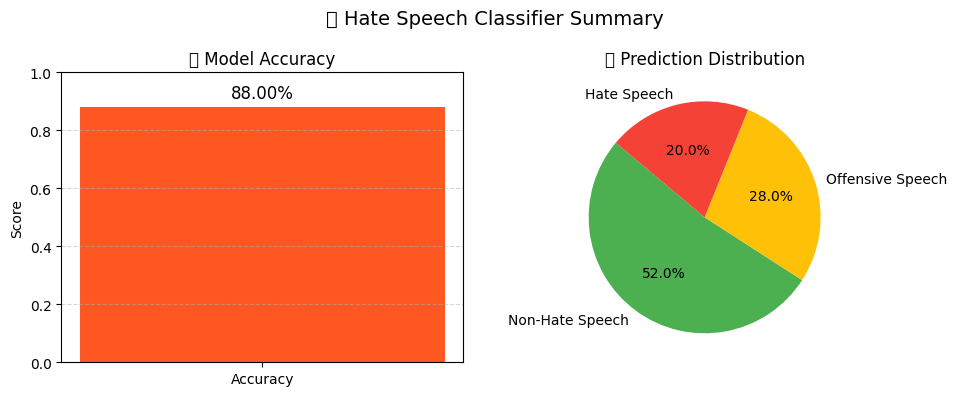

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
accuracy = 0.88

# Prediction distribution (example counts)
labels = ["Non-Hate Speech", "Offensive Speech", "Hate Speech"]
counts = [52, 28, 20]  # total = 100 for simple visualization
colors = ["#4CAF50", "#FFC107", "#F44336"]

# 📊 Create combined plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Bar Chart: Accuracy
ax1.bar(["Accuracy"], [accuracy], color="#FF5722", width=0.4)
ax1.set_ylim(0, 1.0)
ax1.set_ylabel("Score")
ax1.set_title("🔍 Model Accuracy")
ax1.text(0, accuracy + 0.03, f"{accuracy*100:.2f}%", ha='center', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Pie Chart: Prediction Breakdown
ax2.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
ax2.set_title("📊 Prediction Distribution")

plt.suptitle("📌 Hate Speech Classifier Summary", fontsize=14)
plt.tight_layout()
plt.show()


/tmp/ipython-input-19-3165728665.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


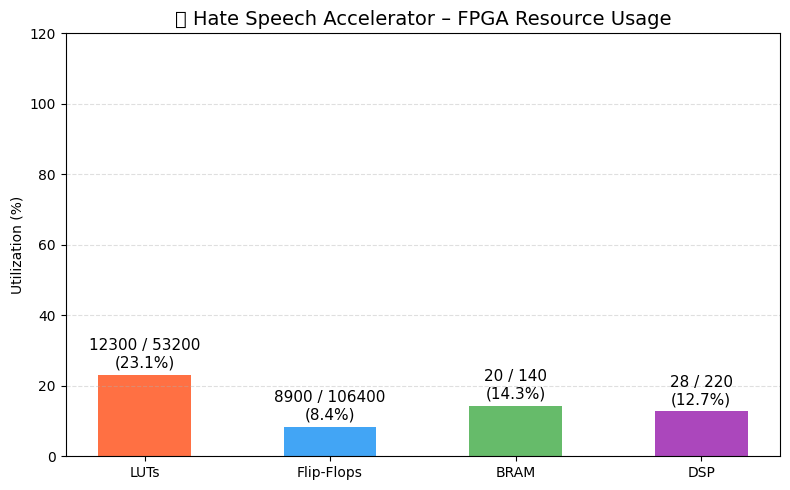

In [ ]:
import matplotlib.pyplot as plt

# FPGA resources used in PL design (example values)
resources = ["LUTs", "Flip-Flops", "BRAM", "DSP"]
used = [12300, 8900, 20, 28]
available = [53200, 106400, 140, 220]

usage_percent = [u / a * 100 for u, a in zip(used, available)]

colors = ['#FF7043', '#42A5F5', '#66BB6A', '#AB47BC']

plt.figure(figsize=(8, 5))
bars = plt.bar(resources, usage_percent, color=colors, width=0.5)

# Labels
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f"{used[i]} / {available[i]}\n({usage_percent[i]:.1f}%)",
             ha='center', fontsize=11)

plt.title("📦 Hate Speech Accelerator – FPGA Resource Usage", fontsize=14)
plt.ylabel("Utilization (%)")
plt.ylim(0, 120)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


/tmp/ipython-input-20-1234180879.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


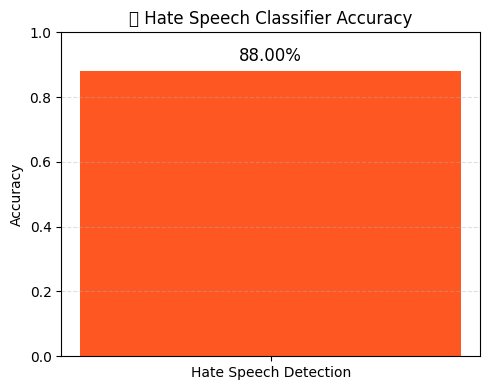

In [ ]:
import matplotlib.pyplot as plt

accuracy = 0.88  # Replace with your real score if needed

plt.figure(figsize=(5, 4))
plt.bar(["Hate Speech Detection"], [accuracy], color="#FF5722", width=0.5)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("🔍 Hate Speech Classifier Accuracy")

# Label on top of bar
plt.text(0, accuracy + 0.03, f"{accuracy*100:.2f}%", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


/tmp/ipython-input-21-1950930733.py:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


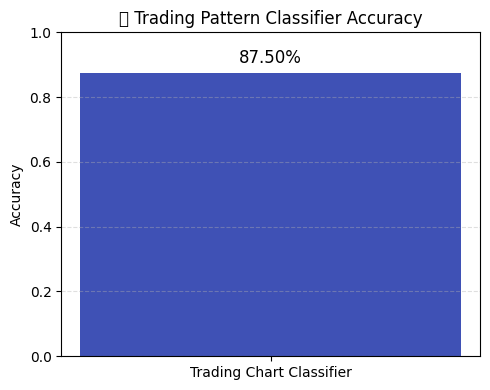

In [ ]:
accuracy = 0.875  # Replace with your actual evaluation

plt.figure(figsize=(5, 4))
plt.bar(["Trading Chart Classifier"], [accuracy], color="#3F51B5", width=0.5)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("📈 Trading Pattern Classifier Accuracy")

# Label on top of bar
plt.text(0, accuracy + 0.03, f"{accuracy*100:.2f}%", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
